In [ ]:
#preprocess_images.py - Optimized
import os
import shutil
import cv2
import numpy as np
from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor

# ============ CONFIG ============
RAW_DATASET = "../../dataset/reduced"
PROCESSED = "../../dataset/processed2"
SEGMENTATION = "../../dataset/segmentation2"
IMG_SIZE = (640, 640)
SPLITS = ["train", "val", "test"]

# Multi-class segmentation (pour classifier les types de dommages)
BINARY_MASK = False  # False = multi-class (6 classes), True = binary (damage/no damage)

# IMPORTANT: NUM_CLASSES = 6 (0=background + 5 damage types)
# Mask values: 0=background, 1-5=damage classes
# This matches the training notebook!
NUM_CLASSES = 6

CLASS_NAMES = {
    0: "Background",
    1: "Longitudinal crack",
    2: "Transverse crack",
    3: "Alligator crack",
    4: "Other damage",
    5: "Pothole"
}

# YOLO label class IDs (0-4) are shifted to mask values (1-5)
# So YOLO class 0 -> mask value 1, YOLO class 4 -> mask value 5

print(f"Config: IMG_SIZE={IMG_SIZE}, BINARY_MASK={BINARY_MASK}, NUM_CLASSES={NUM_CLASSES}")
print(f"Classes: {CLASS_NAMES}")

Config: IMG_SIZE=(640, 640), BINARY_MASK=False, NUM_CLASSES=6
Classes: {0: 'Background', 1: 'Longitudinal crack', 2: 'Transverse crack', 3: 'Alligator crack', 4: 'Pothole', 5: 'Other damage'}


In [7]:
def load_yolo_labels(label_path):
    """Load YOLO format labels from file."""
    boxes = []
    if not os.path.exists(label_path):
        return boxes

    with open(label_path, "r") as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) == 5:
                class_id, x, y, w, h = map(float, parts)
                boxes.append((int(class_id), x, y, w, h))
    return boxes


def yolo_to_mask(boxes, img_shape, binary=False):
    """
    Génère un masque de segmentation à partir des bounding boxes YOLO.
    
    Args:
        boxes: Liste de tuples (class_id, x, y, w, h) en format YOLO normalisé
        img_shape: Tuple (H, W) dimensions de l'image
        binary: Si True, masque binaire (0/1). Si False, masque multi-classe (0-5).
    
    Returns:
        Masque numpy array (values 0-5 for multi-class, 0-1 for binary)
    
    Note:
        - YOLO class IDs are 0-4 (5 damage types)
        - Mask values are 1-5 (shifted by 1, 0 reserved for background)
        - For overlapping boxes, we keep the HIGHER class priority (rarer classes)
    """
    H, W = img_shape
    mask = np.zeros((H, W), dtype=np.uint8)

    # Sort boxes by class_id ASCENDING so that higher class_ids (rarer) overwrite lower ones
    # This gives priority to rarer classes when boxes overlap
    boxes_sorted = sorted(boxes, key=lambda b: b[0])

    for class_id, x, y, bw, bh in boxes_sorted:
        # Convert YOLO normalized coords to pixel coords
        x1 = int((x - bw / 2) * W)
        y1 = int((y - bh / 2) * H)
        x2 = int((x + bw / 2) * W)
        y2 = int((y + bh / 2) * H)

        # Clamp to image bounds
        x1, y1 = max(0, x1), max(0, y1)
        x2, y2 = min(W, x2), min(H, y2)

        if x2 > x1 and y2 > y1:
            if binary:
                # Binary mask: all damage = 1
                mask[y1:y2, x1:x2] = 1
            else:
                # Multi-class: class_id + 1 (0=background, 1-5=damage types)
                # YOLO class 0 -> mask 1, YOLO class 4 -> mask 5
                mask_value = class_id + 1
                mask[y1:y2, x1:x2] = mask_value

    return mask


def process_image(args):
    """Process a single image (for parallel processing)."""
    img_name, raw_img_dir, raw_lbl_dir, proc_img_dir, proc_lbl_dir, seg_img_dir, seg_msk_dir = args
    
    try:
        # Load image
        img_path = os.path.join(raw_img_dir, img_name)
        img = cv2.imread(img_path)
        if img is None:
            return f"[SKIP] Cannot read: {img_name}"

        # Resize
        img = cv2.resize(img, IMG_SIZE, interpolation=cv2.INTER_AREA)

        # Save processed image
        cv2.imwrite(os.path.join(proc_img_dir, img_name), img)
        cv2.imwrite(os.path.join(seg_img_dir, img_name), img)

        # Process labels
        base_name = os.path.splitext(img_name)[0]
        label_name = base_name + ".txt"
        label_path = os.path.join(raw_lbl_dir, label_name)

        # Copy label to processed
        if os.path.exists(label_path):
            shutil.copy(label_path, os.path.join(proc_lbl_dir, label_name))
        else:
            open(os.path.join(proc_lbl_dir, label_name), "w").close()

        # Generate segmentation mask
        boxes = load_yolo_labels(label_path)
        mask = yolo_to_mask(boxes, IMG_SIZE[::-1], binary=BINARY_MASK)  # (H, W)
        
        mask_name = base_name + ".png"
        cv2.imwrite(os.path.join(seg_msk_dir, mask_name), mask)
        
        return None  # Success
        
    except Exception as e:
        return f"[ERROR] {img_name}: {e}"

In [8]:
def run(use_parallel=True, max_workers=4):
    """Run preprocessing with optional parallel processing."""
    
    total_processed = 0
    total_errors = 0
    
    for split in SPLITS:
        print(f"\n{'='*50}")
        print(f"🔄 Processing: {split}")
        print(f"{'='*50}")

        raw_img_dir = os.path.join(RAW_DATASET, split, "images")
        raw_lbl_dir = os.path.join(RAW_DATASET, split, "labels")

        proc_img_dir = os.path.join(PROCESSED, split, "images")
        proc_lbl_dir = os.path.join(PROCESSED, split, "labels")

        seg_img_dir = os.path.join(SEGMENTATION, split, "images")
        seg_msk_dir = os.path.join(SEGMENTATION, split, "masks")

        # Create directories
        for d in [proc_img_dir, proc_lbl_dir, seg_img_dir, seg_msk_dir]:
            os.makedirs(d, exist_ok=True)

        # Get image list
        images = [f for f in os.listdir(raw_img_dir) 
                  if f.lower().endswith(('.jpg', '.png', '.jpeg'))]
        
        if not images:
            print(f"  ⚠️ No images found in {raw_img_dir}")
            continue

        # Prepare arguments
        args_list = [
            (img, raw_img_dir, raw_lbl_dir, proc_img_dir, proc_lbl_dir, seg_img_dir, seg_msk_dir)
            for img in images
        ]

        errors = []
        
        if use_parallel:
            # Parallel processing
            with ThreadPoolExecutor(max_workers=max_workers) as executor:
                results = list(tqdm(
                    executor.map(process_image, args_list),
                    total=len(images),
                    desc=f"  {split}"
                ))
            errors = [r for r in results if r is not None]
        else:
            # Sequential processing
            for args in tqdm(args_list, desc=f"  {split}"):
                result = process_image(args)
                if result:
                    errors.append(result)
        
        # Report
        processed = len(images) - len(errors)
        total_processed += processed
        total_errors += len(errors)
        
        print(f"  ✅ {split}: {processed}/{len(images)} images processed")
        
        if errors:
            print(f"  ⚠️ {len(errors)} errors:")
            for e in errors[:5]:  # Show first 5 errors
                print(f"     {e}")

    print(f"\n{'='*50}")
    print(f"🎉 DONE! {total_processed} images processed, {total_errors} errors")
    print(f"   Output: {PROCESSED}")
    print(f"   Masks:  {SEGMENTATION}")
    print(f"   Mask type: {'Binary (0/1)' if BINARY_MASK else 'Multi-class (0-4)'}")

In [9]:
# Run preprocessing
run(use_parallel=True, max_workers=4)


🔄 Processing: train


  train: 100%|██████████| 2286/2286 [01:01<00:00, 37.26it/s]


  ✅ train: 2286/2286 images processed

🔄 Processing: val


  val: 100%|██████████| 447/447 [00:11<00:00, 37.77it/s]


  ✅ val: 447/447 images processed

🔄 Processing: test


  test: 100%|██████████| 439/439 [00:10<00:00, 39.95it/s]

  ✅ test: 439/439 images processed

🎉 DONE! 3172 images processed, 0 errors
   Output: ../../dataset/processed2
   Masks:  ../../dataset/segmentation2
   Mask type: Multi-class (0-4)



📊 Mask Statistics (train)

   Total masks: 2286
   Unique values found: [np.uint8(0), np.uint8(1), np.uint8(2), np.uint8(3), np.uint8(4), np.uint8(5)]

   Class distribution (masks containing each class):
      0: Background           - 2286 masks (100.0%) | 89.77% pixels
      1: Longitudinal crack   -  686 masks ( 30.0%) |  1.21% pixels
      2: Transverse crack     -  744 masks ( 32.5%) |  0.95% pixels
      3: Alligator crack      -  713 masks ( 31.2%) |  4.12% pixels
      4: Pothole              -  829 masks ( 36.3%) |  3.10% pixels
      5: Other damage         -  789 masks ( 34.5%) |  0.85% pixels

   ✅ Mask values OK for NUM_CLASSES=6
   📊 Background: 89.8% | Foreground: 10.2%


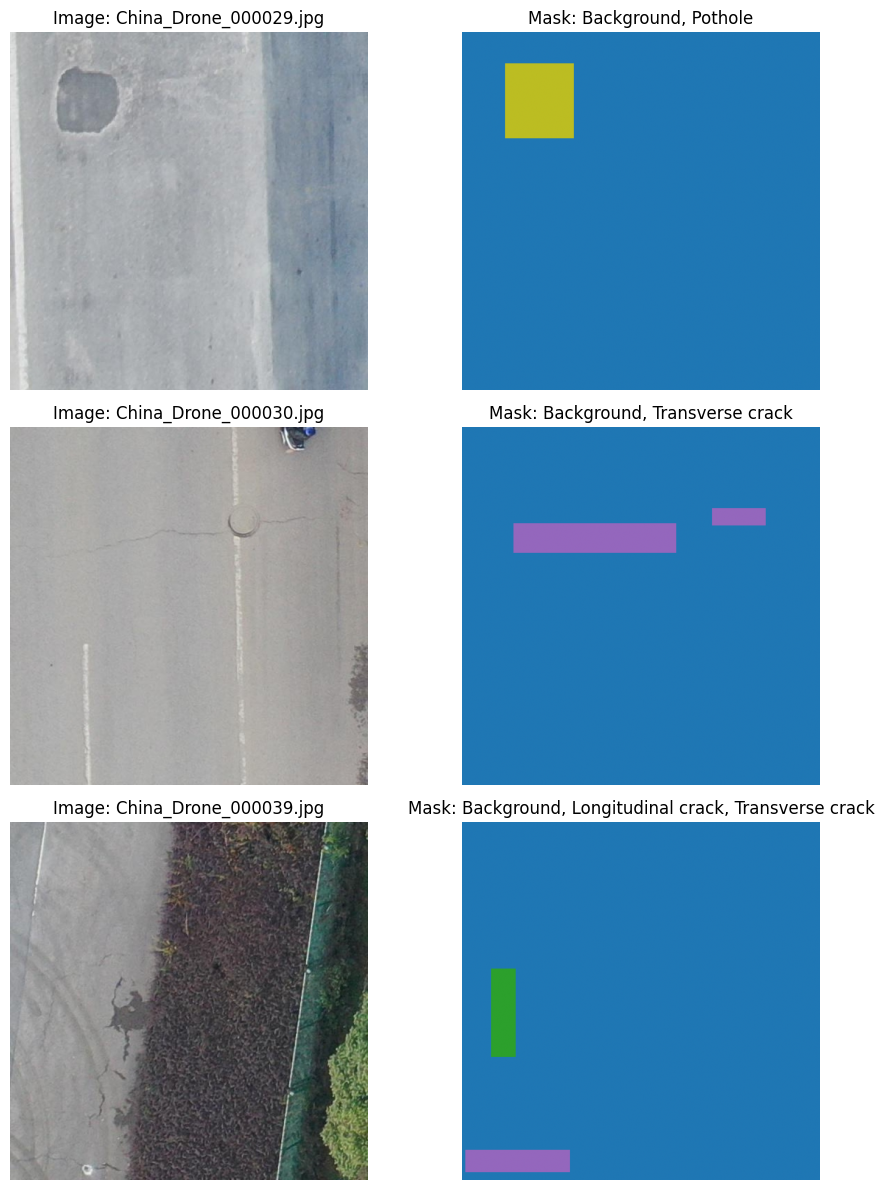

In [10]:
# Verify generated masks (values 0-5 are correct for training!)
import matplotlib.pyplot as plt
from collections import Counter

def verify_masks(split="train", num_samples=3):
    """Verify mask values and visualize samples."""
    
    seg_img_dir = os.path.join(SEGMENTATION, split, "images")
    seg_msk_dir = os.path.join(SEGMENTATION, split, "masks")
    
    images = sorted(os.listdir(seg_img_dir))
    
    print(f"\n{'='*50}")
    print(f"📊 Mask Statistics ({split})")
    print(f"{'='*50}")
    
    # Count masks containing each class
    class_in_masks = Counter()  # How many masks contain each class
    all_values = set()
    total_pixels_per_class = Counter()
    total_pixels = 0
    
    for img_name in images:
        mask_name = os.path.splitext(img_name)[0] + ".png"
        mask = cv2.imread(os.path.join(seg_msk_dir, mask_name), 0)
        if mask is not None:
            unique_vals = np.unique(mask)
            all_values.update(unique_vals)
            for v in unique_vals:
                class_in_masks[v] += 1
                total_pixels_per_class[v] += (mask == v).sum()
            total_pixels += mask.size
    
    print(f"\n   Total masks: {len(images)}")
    print(f"   Unique values found: {sorted(all_values)}")
    print(f"")
    print(f"   Class distribution (masks containing each class):")
    for c in sorted(class_in_masks.keys()):
        name = CLASS_NAMES.get(c, f'Unknown({c})')
        pct = class_in_masks[c] / len(images) * 100
        pix_pct = total_pixels_per_class[c] / total_pixels * 100 if total_pixels > 0 else 0
        print(f"      {c}: {name:20s} - {class_in_masks[c]:4d} masks ({pct:5.1f}%) | {pix_pct:5.2f}% pixels")
    
    # Check for issues
    print(f"")
    if 0 not in all_values:
        print(f"   ⚠️ Warning: No background (0) found - all images have full damage?")
    if max(all_values) > NUM_CLASSES - 1:
        print(f"   ⚠️ Warning: Found class {max(all_values)} but NUM_CLASSES={NUM_CLASSES}")
    else:
        print(f"   ✅ Mask values OK for NUM_CLASSES={NUM_CLASSES}")
    
    # Check imbalance
    if total_pixels > 0:
        bg_pct = total_pixels_per_class.get(0, 0) / total_pixels * 100
        fg_pct = 100 - bg_pct
        print(f"   📊 Background: {bg_pct:.1f}% | Foreground: {fg_pct:.1f}%")
        if bg_pct > 90:
            print(f"   ⚠️ Heavy imbalance! Consider class weighting in training.")
    
    # Visualize
    fig, axes = plt.subplots(num_samples, 2, figsize=(10, 4*num_samples))
    if num_samples == 1:
        axes = axes.reshape(1, -1)
    
    # Pick images that have foreground (more interesting to visualize)
    fg_images = []
    for img_name in images:
        mask_name = os.path.splitext(img_name)[0] + ".png"
        mask = cv2.imread(os.path.join(seg_msk_dir, mask_name), 0)
        if mask is not None and mask.max() > 0:
            fg_images.append(img_name)
        if len(fg_images) >= num_samples:
            break
    
    for i, img_name in enumerate(fg_images[:num_samples]):
        img = cv2.imread(os.path.join(seg_img_dir, img_name))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        mask_name = os.path.splitext(img_name)[0] + ".png"
        mask = cv2.imread(os.path.join(seg_msk_dir, mask_name), 0)
        
        axes[i, 0].imshow(img)
        axes[i, 0].set_title(f"Image: {img_name[:30]}")
        axes[i, 0].axis('off')
        
        axes[i, 1].imshow(mask, cmap='tab10', vmin=0, vmax=NUM_CLASSES-1)
        unique = np.unique(mask)
        class_labels = [CLASS_NAMES.get(v, str(v)) for v in unique]
        axes[i, 1].set_title(f"Mask: {', '.join(class_labels)}")
        axes[i, 1].axis('off')
    
    plt.tight_layout()
    plt.show()

verify_masks("train", num_samples=3)